In [27]:
import pickle
import sys
import csv
sys.path.append(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project')
from execute_remote_scripts import *
# from Processing_Data.downsampling import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
%load_ext autoreload
%autoreload 2
# from Server_Scripts.remote_processing_csv import *
from Processing_Data.EDA import *

from scipy.integrate import simps  # For numerical integration

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Probability Density Functions of the Data

In [13]:
base_path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_Files'
files = os.listdir(base_path)

In [14]:
# Loading all csv files into a diciotnary
dataframes = {}
for file in files:
    dataframes[int(file.split('.')[0].split('no')[1])] = pd.read_csv(os.path.join(base_path, file))
    
RE_autom = list(pd.read_csv(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\automatic_RE_numbers.csv', header=None)[0])
RE_valid = list(pd.read_csv(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\validated_RE_numbers.csv', header=None)[0])

In [ ]:
# Checking for NaNs and Infs and dropping them if necessary
check_nans_infs(dataframes, drop=True)

# Updating the shot lists
RE_autom = [shot for shot in RE_autom if shot in dataframes.keys()]
RE_valid = [shot for shot in RE_valid if shot in dataframes.keys()]
NO_RE_probably = [key for key in dataframes.keys() if key not in RE_autom and key not in RE_valid]

# Extracting the keys of the variables
features = list(dataframes[NO_RE_probably[0]].keys()) #to_numpy()
features.pop(features.index('time'))
features

Dropped DataFrames: []


In [22]:
# Getting the normalised PDFs
RE_features_extrema, RE_features_densities = compute_feature_statistics(dataframes, RE_valid, features)
NO_RE_features_extrema, NO_RE_features_densities = compute_feature_statistics(dataframes, NO_RE_probably, features) 

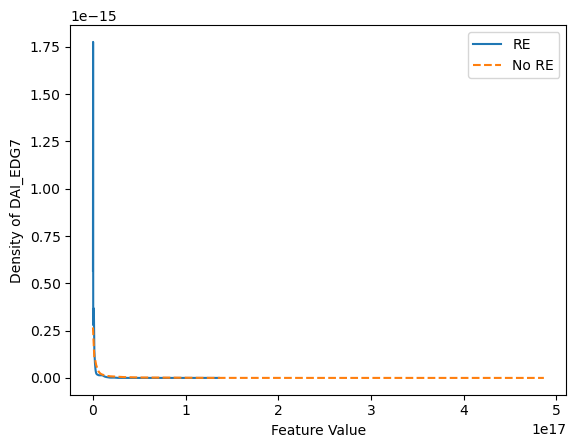

In [ ]:
# Plotting and saving them all (log scale optional)
plt.close()
for feature in features:
    plt.close()
    plt.plot(RE_features_densities[feature][0], RE_features_densities[feature][1], label='RE')
    plt.plot(NO_RE_features_densities[feature][0], NO_RE_features_densities[feature][1], '--', label='No RE')
    plt.xlabel('Feature Value')
    plt.ylabel(f'Density of {feature}')
    plt.legend()
    # plt.loglog()
    plt.savefig(fr'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\PDFs_DAI\Feature_Density_{feature}.png')

## Comparing original data with downsampled data

In [5]:
file_original = load_pickle(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\20_random_JET_data.pkl')
original_data = file_original['JETno85000']
downsampled_data = pd.read_csv(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_Files\JETno85000.csv') # These data are downsampled while downloaded

In [11]:
SSX = shot['SSXcore']
t_b = shot['Ramp_up'][0]
t_e = shot['Ramp_down'][1]
original_time = SSX['time'][(SSX['time'] >= t_b) & (SSX['time'] <= t_e)]
original_data = SSX['signal'][(SSX['time'] >= t_b) & (SSX['time'] <= t_e)]
print(t_b, t_e)

40.917400001490115 59.467300001490116


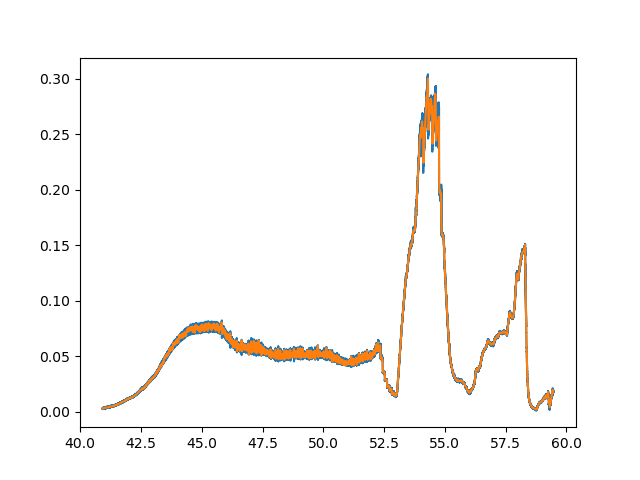

In [12]:
plt.close()
plt.plot(original_time, original_data)
plt.plot(downsampled_data['time'], downsampled_data['SSXcore'], '-')
plt.show()